# To test understanding of Applied Bayesian Modelling

### I am roughly following this textbook: https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
import theano
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"

In [159]:
import theano.tensor as tt

In [2]:
from matplotlib import rc

# The following is code to set defaults for Matplotlib graphs
rc('font',**{'family':'serif','weight':'light', 'size':20})
rc('text', usetex=False)
rc('ytick', labelsize = 15)
rc('xtick', labelsize = 15)
rc('figure', **{'titlesize':20, 'titleweight':'light', 'figsize':(15,8)})
rc('legend', **{'fontsize':20, 'frameon': False})
rc('axes', **{'labelsize':18, 
                'labelweight':'light', 
                'spines.top': 'False', 'spines.right':'False',
                'prop_cycle':  """cycler('color',['2476AB', 'EF9C34', 'D22C2C', 
                            'E5D81D', '8E44AD','1EB22C', '38C6BE','C638A2'])""",
                'titlesize': 25, 'titleweight': 'light'
    })

In [4]:
import pymc3 as pm

In [5]:
from pymc3 import model_to_graphviz
from pymc3 import sample_prior_predictive
from pymc3 import sample

from arviz import plot_posterior
import arviz as az

# Linear Regression

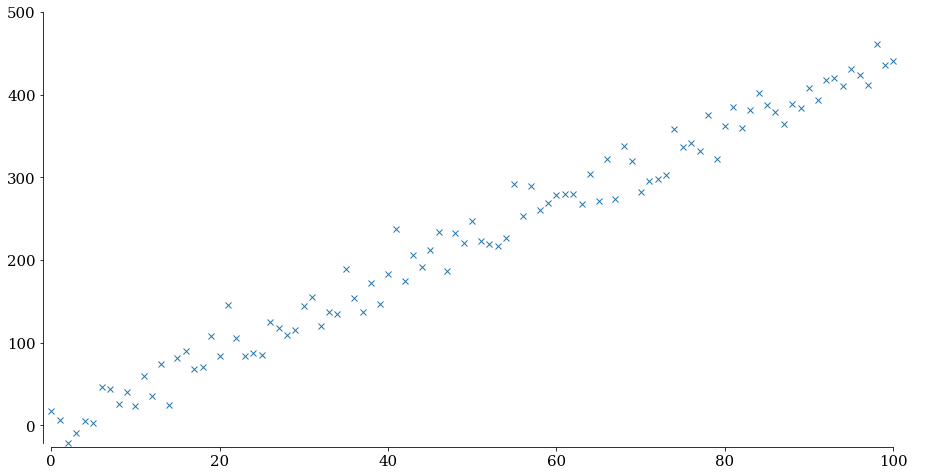

In [7]:
def roundup(x):
    return x if x % 100 == 0 else x + 100 - x % 100

X = np.linspace(0,100,101)

μ_real = 4.5

# Add a "jitter"
y_true = μ_real * X + pm.Normal.dist(0,20).random(size=len(X))

fig,ax = plt.subplots(figsize=(16,8))
plt.plot(X, y_true, marker= 'x', ls='')

ax.set_xlim(X.min()-(X.max() - X.min())/100)
ax.set_ylim(y_true.min()-(roundup(y_true.max() - y_true.min())/100), roundup(y_true.max()))

ax.spines['bottom'].set_bounds(X.min(), X.max())
ax.spines['left'].set_bounds(y_true.min(), roundup(y_true.max()))

In [11]:
# Frequentist approach
X_hat = np.array([[1 for i in range(len(X))], X]).T

μ_est_lin = np.linalg.inv(X_hat.T@X_hat) @ X_hat.T @ y_true

In [12]:
def line_reg(beta, x):
    return beta[1]*x[:,1] + beta[0]*x[:,0]

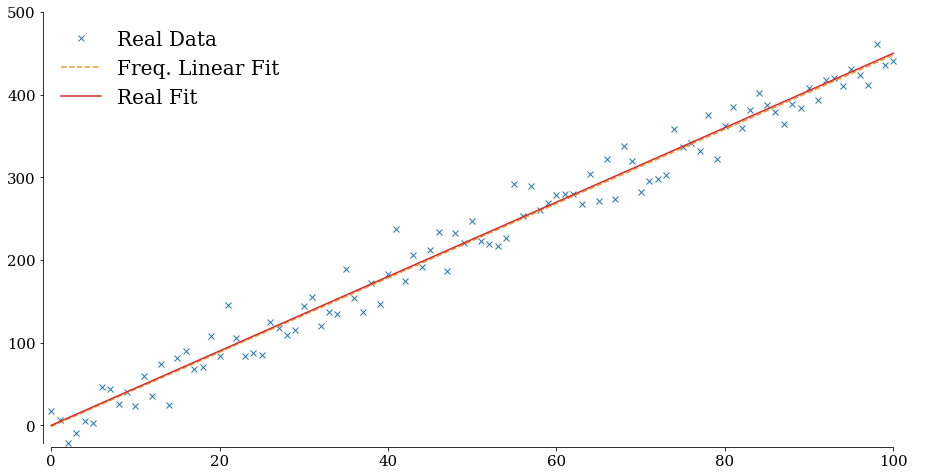

In [23]:
fig,ax = plt.subplots(figsize=(16,8))
plt.plot(X_hat[:,1], y_true, marker= 'x', ls='', label = 'Real Data')
plt.plot(X, line_reg(μ_est_lin, X_hat), ls='--', label = 'Freq. Linear Fit')
plt.plot(X, μ_real*X, label = 'Real Fit')

ax.set_xlim(X.min()-(X.max() - X.min())/100)
ax.set_ylim(y_true.min()-(roundup(y_true.max() - y_true.min())/100), roundup(y_true.max()))

ax.spines['bottom'].set_bounds(X.min(), X.max())
ax.spines['left'].set_bounds(y_true.min(), roundup(y_true.max()))

plt.legend()

In [15]:
# Bayesian Approach
with pm.Model() as b_linear:
    m = pm.Normal('m', 0, 20)
    c = pm.Normal('c', 0, 10)
    
    σ = pm.HalfNormal('σ', 20)
    
    likelihood = pm.Normal('y', mu = m*X + c, sigma = σ, observed = y_true)

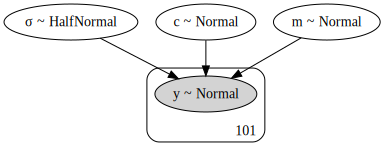

In [16]:
model_to_graphviz(b_linear)

In [18]:
with b_linear:
    prior_sample = sample_prior_predictive(1000)
    samples = sample(1000, tune=1000, cores=2, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, c, m]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1700.33draws/s]


/Users/joseph_cross/Anaconda/anaconda3/envs/bayes_course/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/joseph_cross/Anaconda/anaconda3/envs/bayes_course/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/joseph_cross/Anaconda/anaconda3/envs/bayes_course/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


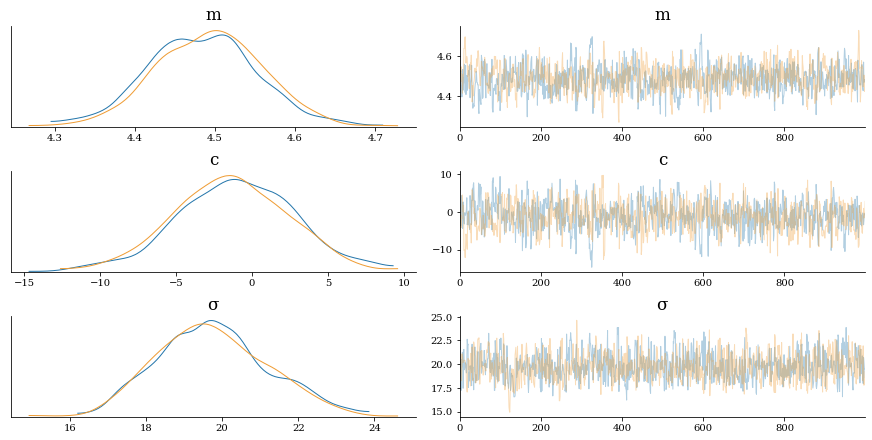

In [19]:
az.plot_trace(samples);

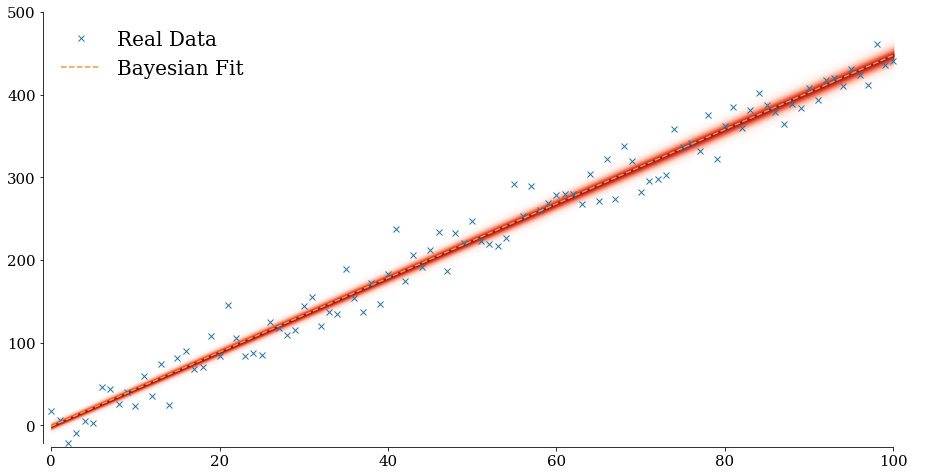

In [27]:
fig,ax = plt.subplots(figsize=(16,8))
plt.plot(X, y_true, marker= 'x', ls='', label = 'Real Data')
plt.plot(X, line_reg([samples['c'].mean(), samples['m'].mean()], X_hat), ls='--', label = 'Bayesian Fit')
x = X
fill_alpha = 0.1
palette = 'Reds'
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))

for i, p in enumerate(percs[::-1]):
    upper_m = np.percentile(samples['m'], p)
    lower_m = np.percentile(samples['m'], 100-p)
    
    upper_c = np.percentile(samples['c'], p)
    lower_c = np.percentile(samples['c'], 100-p)
    
    y_upper = upper_m * x + upper_c
    y_lower = lower_m * x + lower_c
    
    color_val = colors[i]
    
    ax.fill_between(x, y_upper, y_lower, color=cmap(color_val), alpha=fill_alpha)
ax.set_xlim(X.min()-(X.max() - X.min())/100)
ax.set_ylim(y_true.min()-(roundup(y_true.max() - y_true.min())/100), roundup(y_true.max()))

ax.spines['bottom'].set_bounds(X.min(), X.max())
ax.spines['left'].set_bounds(y_true.min(), roundup(y_true.max()))
plt.legend()
plt.show()

## Poisson / Count

In [28]:
import os

In [29]:
data_folder = "./Data"
data_name = 'text_data.csv'

In [30]:
df_text = pd.read_csv(os.path.join(data_folder, data_name), header=None, names=['Count'])

Text(0.5, 0, 'Day')

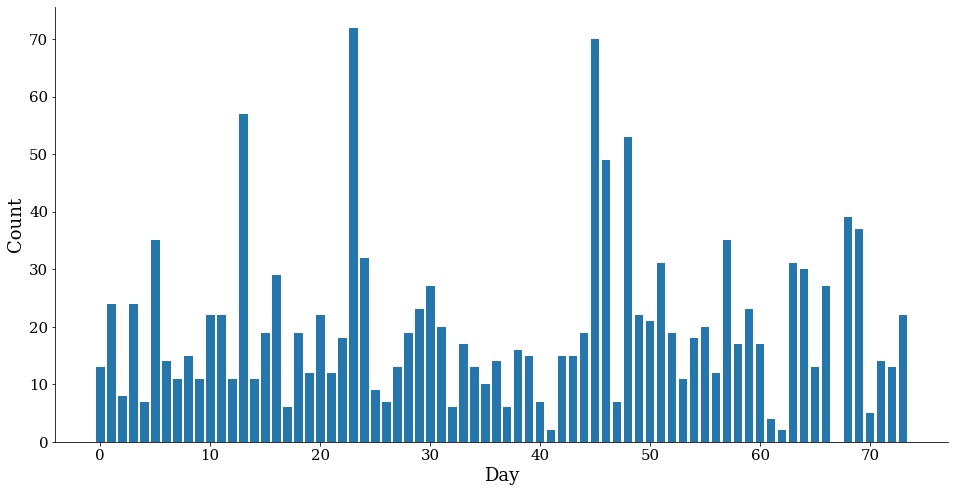

In [31]:
fig, ax = plt.subplots(figsize = (16,8))
ax.bar(df_text.index,height=df_text['Count'])
ax.set_ylabel("Count")
ax.set_xlabel("Day")

In [32]:
n_count_data = len(df_text)

In [ ]:
# Count data can be described by a Poisson distribution
# Where lambda is the parameter of interest
# Here we speculate that lambda can have values given by exp(alpha)
# We have no knowledge of alpha, so we could either use a set value, or just allow many values

In [33]:
with pm.Model() as poisson_model:
    α_1 = pm.HalfNormal('α_1',1)
    α_2 = pm.HalfNormal('α_2',1)
    
    λ_1 = pm.Exponential('λ_1',α_1)
    λ_2 = pm.Exponential('λ_2',α_2)
    
    τ = pm.DiscreteUniform('τ',1,n_count_data+1)

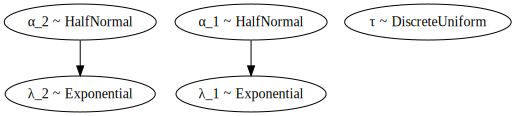

In [34]:
model_to_graphviz(poisson_model)

In [ ]:
# The consideration here is; has the number of texts per day changed
# We use the "switch" function to suggest there is one count rate before the change
# and a different one afterwards.

In [35]:
with poisson_model:
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(τ > idx, λ_1, λ_2)

with poisson_model:
    observation = pm.Poisson("obs", lambda_, observed=df_text['Count'].values)

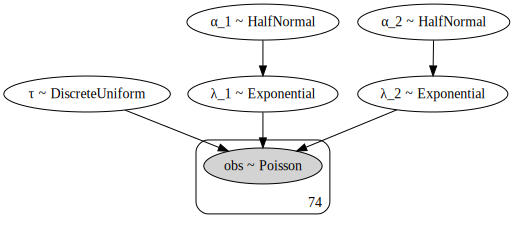

In [36]:
model_to_graphviz(poisson_model)

In [37]:
with poisson_model:
    samples = sample(1000, tune=1000, cores=1, random_seed=42)

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [λ_2, λ_1, α_2, α_1]
>Metropolis: [τ]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1345.61it/s]
The number of effective samples is smaller than 25% for some parameters.


/Users/joseph_cross/Anaconda/anaconda3/envs/bayes_course/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/joseph_cross/Anaconda/anaconda3/envs/bayes_course/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/joseph_cross/Anaconda/anaconda3/envs/bayes_course/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/joseph_cross/Anaconda/anaconda3/envs/bayes_course/lib/python3.7/site-packages/arv

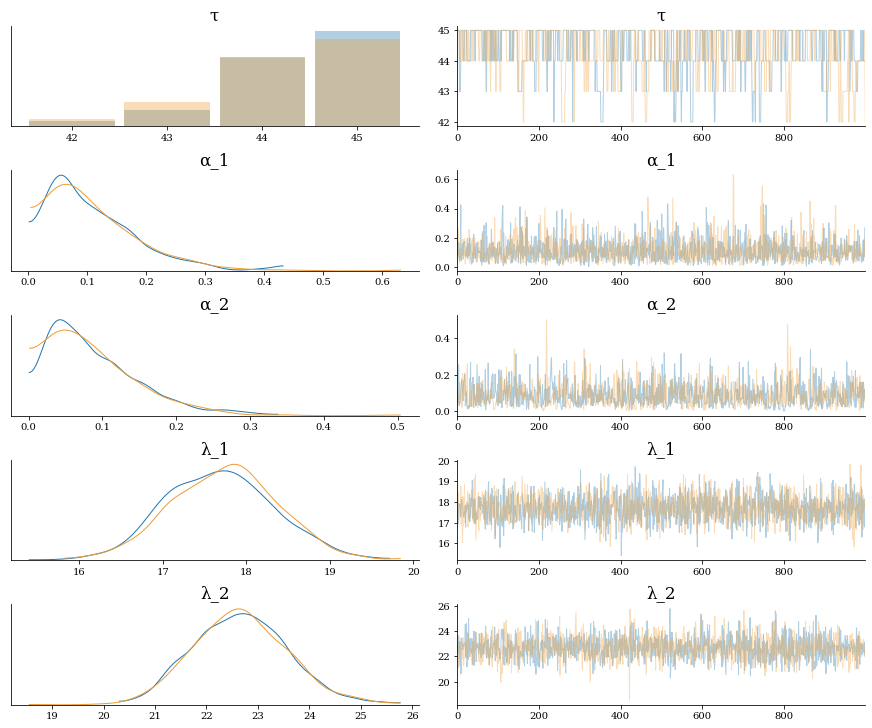

In [38]:
az.plot_trace(samples);

## A/B Testing

In [39]:
# Consider people visiting a site, and we have no particular idea about the likelihood of a conversion

In [65]:
with pm.Model() as single_A:
    p = pm.Uniform('p', lower=0, upper=1)

In [56]:
#set "known" constants to generate distribution
p_true = 0.05  
N = 1500

# sample N Bernoulli random variables from Ber(0.05).
# each random variable has a 0.05 chance of being a 1.
# this is the data-generation step
occurrences = pm.Bernoulli.dist(p_true).random(size=N)

print(occurrences) 
print(np.sum(occurrences))

[0 0 0 ... 0 0 0]
73


In [58]:
# Occurrences.mean is equal to n/N.
print(f"Observed frequency: (no. true / total) {np.mean(occurrences):.4f}" )
print(f"True frequency: {p_true}")

Observed frequency: (no. true / total) 0.0487
True frequency: 0.05


In [66]:
#include the observations, which are Bernoulli
with single_A:
    obs = pm.Bernoulli("obs", p, observed=occurrences)
    trace = pm.sample(1000)
    burned_trace = trace[100:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:01<00:00, 4917.32draws/s]


/Users/joseph_cross/Anaconda/anaconda3/envs/bayes_course/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


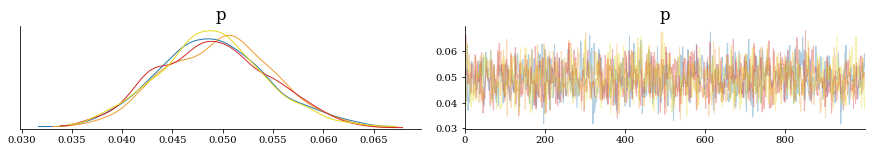

In [67]:
az.plot_trace(trace);

/Users/joseph_cross/Anaconda/anaconda3/envs/bayes_course/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


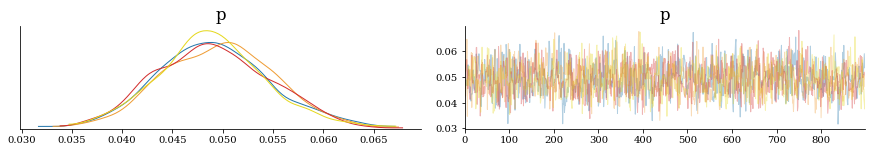

In [68]:
az.plot_trace(burned_trace);

In [69]:
# Now consider B, which is a different website
# We want to compare the conversion rates

In [72]:
# Real values (unknown to model)
p_A = 0.05
p_B = 0.04

N_A = 1500
N_B = 750

occurrences_A = pm.Bernoulli.dist(p_A).random(size=N_A)
occurrences_B = pm.Bernoulli.dist(p_B).random(size=N_B)

In [73]:
print(f"Observed frequency A: (no. true / total) {np.mean(occurrences_A):.4f}, True frequency A: {p_A}" )
print(f"Observed frequency B: (no. true / total) {np.mean(occurrences_B):.4f}, True frequency B: {p_B}" )

Observed frequency A: (no. true / total) 0.0480, True frequency A: 0.05
Observed frequency B: (no. true / total) 0.0373, True frequency B: 0.04


In [75]:
with pm.Model() as AB_model:
    p_A_dist = pm.Uniform('p_A_dist', 0,1)
    p_B_dist = pm.Uniform('p_B_dist', 0,1)
    
    obs_A = pm.Bernoulli('obs_A', p_A_dist, observed = occurrences_A)
    obs_B = pm.Bernoulli('obs_B', p_B_dist, observed = occurrences_B)
    
    δ = pm.Deterministic('δ', p_A_dist - p_B_dist)
    
    

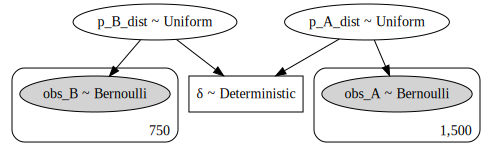

In [76]:
model_to_graphviz(AB_model)

In [77]:
with AB_model:
    samples = pm.sample(2000)
    burned_in = samples[500:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_B_dist, p_A_dist]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:01<00:00, 5131.80draws/s]


/Users/joseph_cross/Anaconda/anaconda3/envs/bayes_course/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/joseph_cross/Anaconda/anaconda3/envs/bayes_course/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


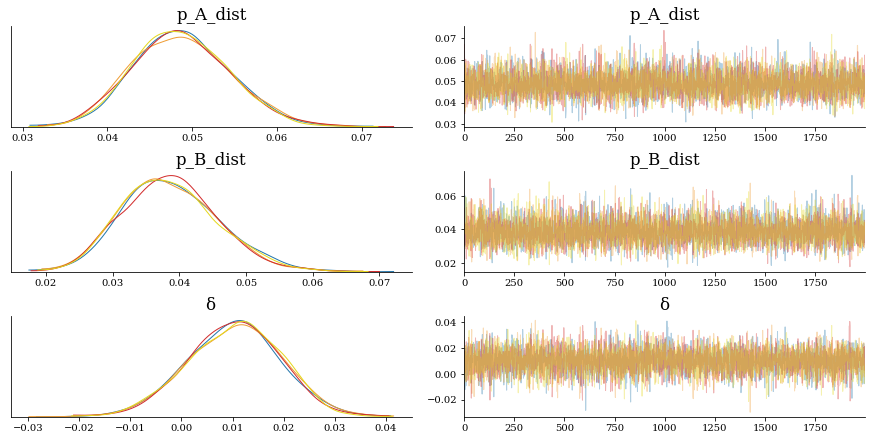

In [88]:
az.plot_trace(samples);

In [86]:
?? az.plot_trace

In [80]:
δ_samples = samples['δ']

In [82]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(δ_samples < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(δ_samples > 0))

Probability site A is WORSE than site B: 0.130
Probability site A is BETTER than site B: 0.870


# Space Shuttle Failure Example

In [119]:
df_shuttle = pd.read_pickle(os.path.join(data_folder, "shuttle_failure.pkl"))

In [120]:
df_shuttle

,Temp. (F),Failure
0,66,0
1,70,1
2,69,0
3,68,0
4,67,0
5,72,0
6,73,0
7,70,0
8,57,1
9,63,1


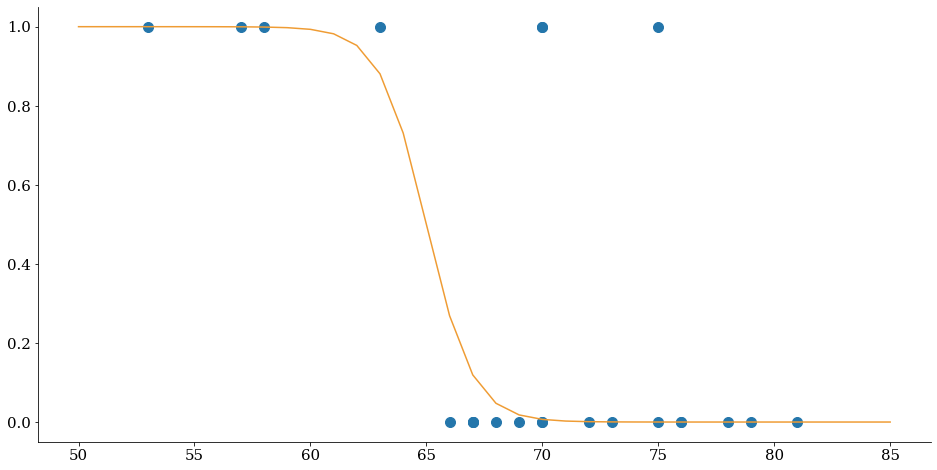

In [155]:
fig,ax = plt.subplots(figsize = (16,8))
plt.plot(df_shuttle['Temp. (F)'], df_shuttle['Failure'], ls='', marker = '.', ms=20)
plt.plot(x,y)

In [138]:
def logit_func(x, alpha, beta):
    return  1 / (1+np.exp(beta*x+alpha))

In [152]:
x = np.linspace(50,85, 36)

In [153]:
y = [logit_func(i, -65, 1) for i in x]

In [171]:
with pm.Model() as shuttle_model:
    α = pm.Normal('α', mu = -60, sigma = 10, testval = 0)
    β = pm.Normal('β', mu = 0, sigma = 10, testval = 0)
    
    logit = pm.Deterministic('logit', 1/(1+ tt.exp(β * df_shuttle['Temp. (F)'].values + α)))

In [172]:
with shuttle_model:
    likelihood = pm.Bernoulli('likelihood', logit, observed = df_shuttle['Failure'].values)

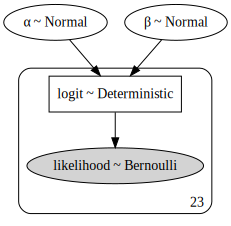

In [173]:
model_to_graphviz(shuttle_model)

In [174]:
with shuttle_model:
    
    start = pm.find_MAP()
    samples = pm.sample(2000, start = start)
    burned_in = samples[500:]

logp = -21.886, ||grad|| = 61.487: 100%|██████████| 27/27 [00:00<00:00, 3038.54it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:06<00:00, 1490.61draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [181]:
samples['α'].mean()

-43.67410835403116

In [182]:
samples['β'].mean()

0.6535609223666045

/Users/joseph_cross/Anaconda/anaconda3/envs/bayes_course/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/joseph_cross/Anaconda/anaconda3/envs/bayes_course/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


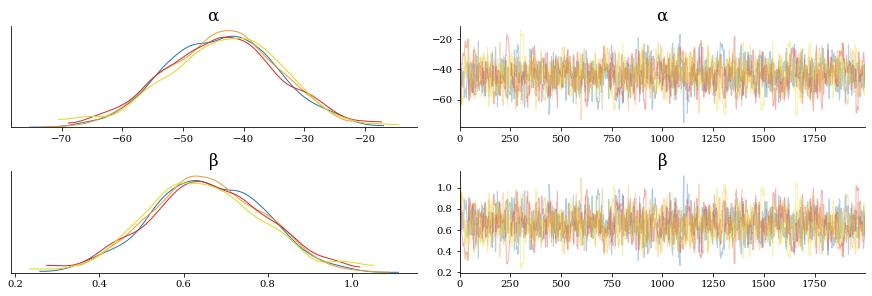

In [180]:
az.plot_trace(samples, var_names=['α', 'β']);